In [18]:
!nvidia-smi

Tue May 26 21:03:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   50C    P0    68W / 300W |  31397MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   44C    P0    70W / 300W |    317MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [ ]:
!kill -9  96349
!kill -9  7370 

In [ ]:
!nvidia-smi

In [1]:
# tensorflow와 tf.keras를 임포트
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
#train x,y데이터 불러오기
X1 = np.load('/home/ubuntu/SDL/kmy/train/chunks_160x160_NORMvsDISTRESS_50k_train_chunk_00_x.npy')

Y1 = np.load('/home/ubuntu/SDL/kmy/train/chunks_160x160_NORMvsDISTRESS_50k_train_chunk_00_y.npy')



In [3]:
#validation x,y데이터 불러오기
A1 = np.load('/home/ubuntu/SDL/kmy/valid/chunks_160x160_NORMvsDISTRESS_50k_valid_chunk_0_x.npy')

B1 = np.load('/home/ubuntu/SDL/kmy/valid/chunks_160x160_NORMvsDISTRESS_50k_valid_chunk_0_y.npy')


In [4]:
#test 데이터 불러오기
C1 = np.load('/home/ubuntu/SDL/kmy/test/chunks_160x160_NORMvsDISTRESS_50k_test_chunk_0_x.npy')

D1 = np.load('/home/ubuntu/SDL/kmy/test/chunks_160x160_NORMvsDISTRESS_50k_test_chunk_0_y.npy')


In [5]:
#데이터 자르기
X=X1[0:999]
Y=Y1[0:999]
Xvalid=A1[0:199]
Yvalid=B1[0:199]
Xtest=C1[0:199]
Ytest=D1[0:199]
#데이터 shape 확인
print(np.shape(X))
print(np.shape(Y))
print(np.shape(Xvalid))
print(np.shape(Yvalid))
print(np.shape(Xtest))
print(np.shape(Ytest))

(999, 1, 160, 160)
(999,)
(199, 1, 160, 160)
(199,)
(199, 1, 160, 160)
(199,)


In [6]:
#데이터 배열 바꾸기
X=np.squeeze(X,axis=1)
X=np.expand_dims(X,axis=3)

Xvalid=np.squeeze(Xvalid,axis=1)
Xvalid=np.expand_dims(Xvalid,axis=3)

Xtest=np.squeeze(Xtest,axis=1)
Xtest=np.expand_dims(Xtest,axis=3)

#바꾼 배열 확인
print(np.shape(Xvalid))
print(np.shape(Xtest))
print(np.shape(X))

(199, 160, 160, 1)
(199, 160, 160, 1)
(999, 160, 160, 1)


In [7]:
#데이터 augmentation (상하,좌우 반전)
import cv2
X2=[]
X3=[]
X4=[]
for i in range(len(X)):
    X2.append(cv2.flip(X[i], 1) ) #좌우반전
 
for j in range(len(X)):
    X3.append(cv2.flip(X[j], 0)) #상하반전
 

for k in range(len(X2)):
    X4.append(cv2.flip(X2[k], 0))#상하좌우
    
#데이터 배열 바꾸기     
X2=np.expand_dims(X2,axis=3)
X3=np.expand_dims(X3,axis=3)    
X4=np.expand_dims(X4,axis=3)

print(np.shape(X2))

(999, 160, 160, 1)


In [8]:
#여러 데이터 파일 하나로 합치기
Xtrain=np.concatenate((X,X2,X3,X4), axis=0)
Ytrain=np.concatenate((Y,Y,Y,Y), axis=0)
print(np.shape(Xtrain))
print(np.shape(Ytrain))

(3996, 160, 160, 1)
(3996,)


In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [10]:
# 텐서플로우 버전확인
print(tf.__version__)     
print(keras.__version__)

1.15.2
2.2.4-tf


In [11]:
# 러닝레이트 
training_epochs = 100  # 에폭
batch_size = 64     # 배치사이즈


In [12]:
# he, xavier
from keras import regularizers
def create_model():
    inputs = keras.Input(shape=(160,160,1))
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01),kernel_initializer = 'he_normal', bias_initializer = 'zeros')(inputs)
     #레이어의 초기 임의 weight를 설정(random normal: 정규 분포로 텐서를 생성하는 이니셜 라이저), weight 정규화:(L2, 0.01), bias: 0값으로 초기화
    conv2 = keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(conv1)
    conv3 = keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(conv2)
    pool1 = keras.layers.MaxPool2D(padding='SAME')(conv3) #Maxpooling 사용
    
    conv4 = keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(pool1)
    conv5 = keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(conv4)
    conv6= keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(conv5)
    pool2 = keras.layers.MaxPool2D(padding='SAME')(conv6)
        
    conv7 = keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(pool2)
    conv8 = keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(conv7)
    conv9 = keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(conv8)
    pool3 = keras.layers.MaxPool2D(padding='SAME')(conv9)
   
    conv10 = keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(pool3)
    conv11 = keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01), name='target_conv')(conv10)
    conv12 = keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(conv11)
    pool4 = keras.layers.MaxPool2D(padding='SAME')(conv12)
    drop0 = keras.layers.Dropout(rate=0.5)(pool4) #drop out 0.5 사용
    
    pool4_flat = keras.layers.Flatten()(drop0)
    dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(pool4_flat)
    drop1 = keras.layers.Dropout(rate=0.5)(dense4)
    dense5 = keras.layers.Dense(units=128, activation=tf.nn.relu,kernel_regularizer = regularizers.l2(0.01))(drop1) 
    drop2 = keras.layers.Dropout(rate=0.4)(dense5)
    logits = keras.layers.Dense(units=2,activation= 'sigmoid')(drop2) 
    return keras.Model(inputs=inputs, outputs=logits)

In [13]:
model= create_model()
model.summary() # 모델에 대한 요약 출력

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 64)        18496     
______________________________________________

In [31]:
import keras.backend as K

# 모델 컴파일 진행 Adam Optimizer 사용
model.compile(loss='sparse_categorical_crossentropy',  
              optimizer=keras.optimizers.Adam(learning_rate=0.00009),               
              metrics=['accuracy'])    
# 학습실행

history = model.fit(Xtrain, Ytrain, 
          batch_size=batch_size, 
          epochs=training_epochs, 
          verbose=1,                 # verbose는 학습 중 출력되는 문구를 설정하는 것 
          validation_data=(Xvalid, Yvalid)) # test를 val로 사용
score = model.evaluate(Xtest, Ytest, verbose=0) # test 값 결과 확인
print('test_loss :', score[0])

Train on 3996 samples, validate on 199 samples
Epoch 1/100
3996/3996 [==============================] - 6s 2ms/sample - loss: 0.7008 - acc: 0.8371 - val_loss: 0.9833 - val_acc: 0.6382
Epoch 2/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.6922 - acc: 0.8448 - val_loss: 0.8451 - val_acc: 0.7839
Epoch 3/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.6901 - acc: 0.8483 - val_loss: 0.8603 - val_acc: 0.7487
Epoch 4/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.6773 - acc: 0.8433 - val_loss: 0.8243 - val_acc: 0.7990
Epoch 5/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.6921 - acc: 0.8451 - val_loss: 0.8005 - val_acc: 0.8040
Epoch 6/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.6881 - acc: 0.8426 - val_loss: 0.8475 - val_acc: 0.7889
Epoch 7/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.6752 - acc: 0.8589 - val_loss: 0.8248 - val_acc: 0

3996/3996 [==============================] - 4s 1ms/sample - loss: 0.5827 - acc: 0.8809 - val_loss: 0.7233 - val_acc: 0.8241
Epoch 61/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.6042 - acc: 0.8616 - val_loss: 0.8044 - val_acc: 0.7688
Epoch 62/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.5745 - acc: 0.8799 - val_loss: 0.7105 - val_acc: 0.8392
Epoch 63/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.5720 - acc: 0.8796 - val_loss: 0.7154 - val_acc: 0.8543
Epoch 64/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.5748 - acc: 0.8764 - val_loss: 0.7979 - val_acc: 0.7688
Epoch 65/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.5699 - acc: 0.8829 - val_loss: 0.8748 - val_acc: 0.7337
Epoch 66/100
3996/3996 [==============================] - 4s 1ms/sample - loss: 0.5890 - acc: 0.8716 - val_loss: 0.7272 - val_acc: 0.8191
Epoch 67/100
3996/3996 [=======================

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 모델 학습 후 정보가 담긴 history 내용을 토대로 선 그래프를 그리는 함수 설정

def plot_acc(history, title=None):        # Accuracy(정확도) Visualization
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['acc'])        # accuracy
    plt.plot(history['val_acc'])    # validation accuracy
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

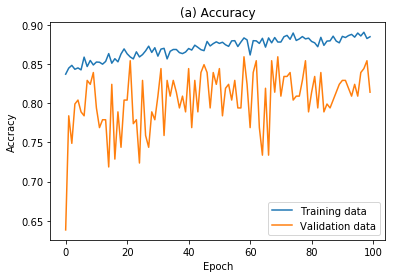

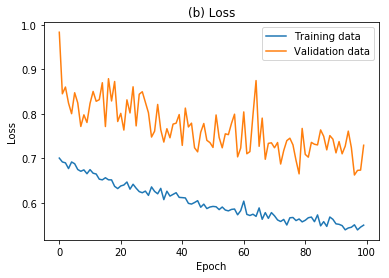

In [33]:
# Visualization
plot_acc(history, '(a) Accuracy')  # 학습 경과에 따른 정확도 변화 추이
plt.show()
plot_loss(history, '(b) Loss')     # 학습 경과에 따른 손실값 변화 추이
plt.show()

In [34]:
score = model.evaluate(Xtest, Ytest, verbose=0) # test 값 결과 확인
print('test-acc :', score[1])

test-acc : 0.8592965


In [18]:
predictions = model.predict(Xtest)
predictions[120]

array([0.43643484, 0.23139751], dtype=float32)

In [19]:

#test 데이터의 이미지들, 정답 여부와 예측 확신 퍼센트를 보여주는 함수
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label = np.argmax(predictions_array)
    plt.imshow(np.array(np.squeeze(img)),cmap='gray')
    if predicted_label == true_label:
        color = 'blue'            #정확하게 예측했으면, 파란색 글씨
    else : 
        color = 'red'             #잘못 예측했으면, 빨간색 글씨
    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label, 100*np.max(predictions_array), true_label),color=color)

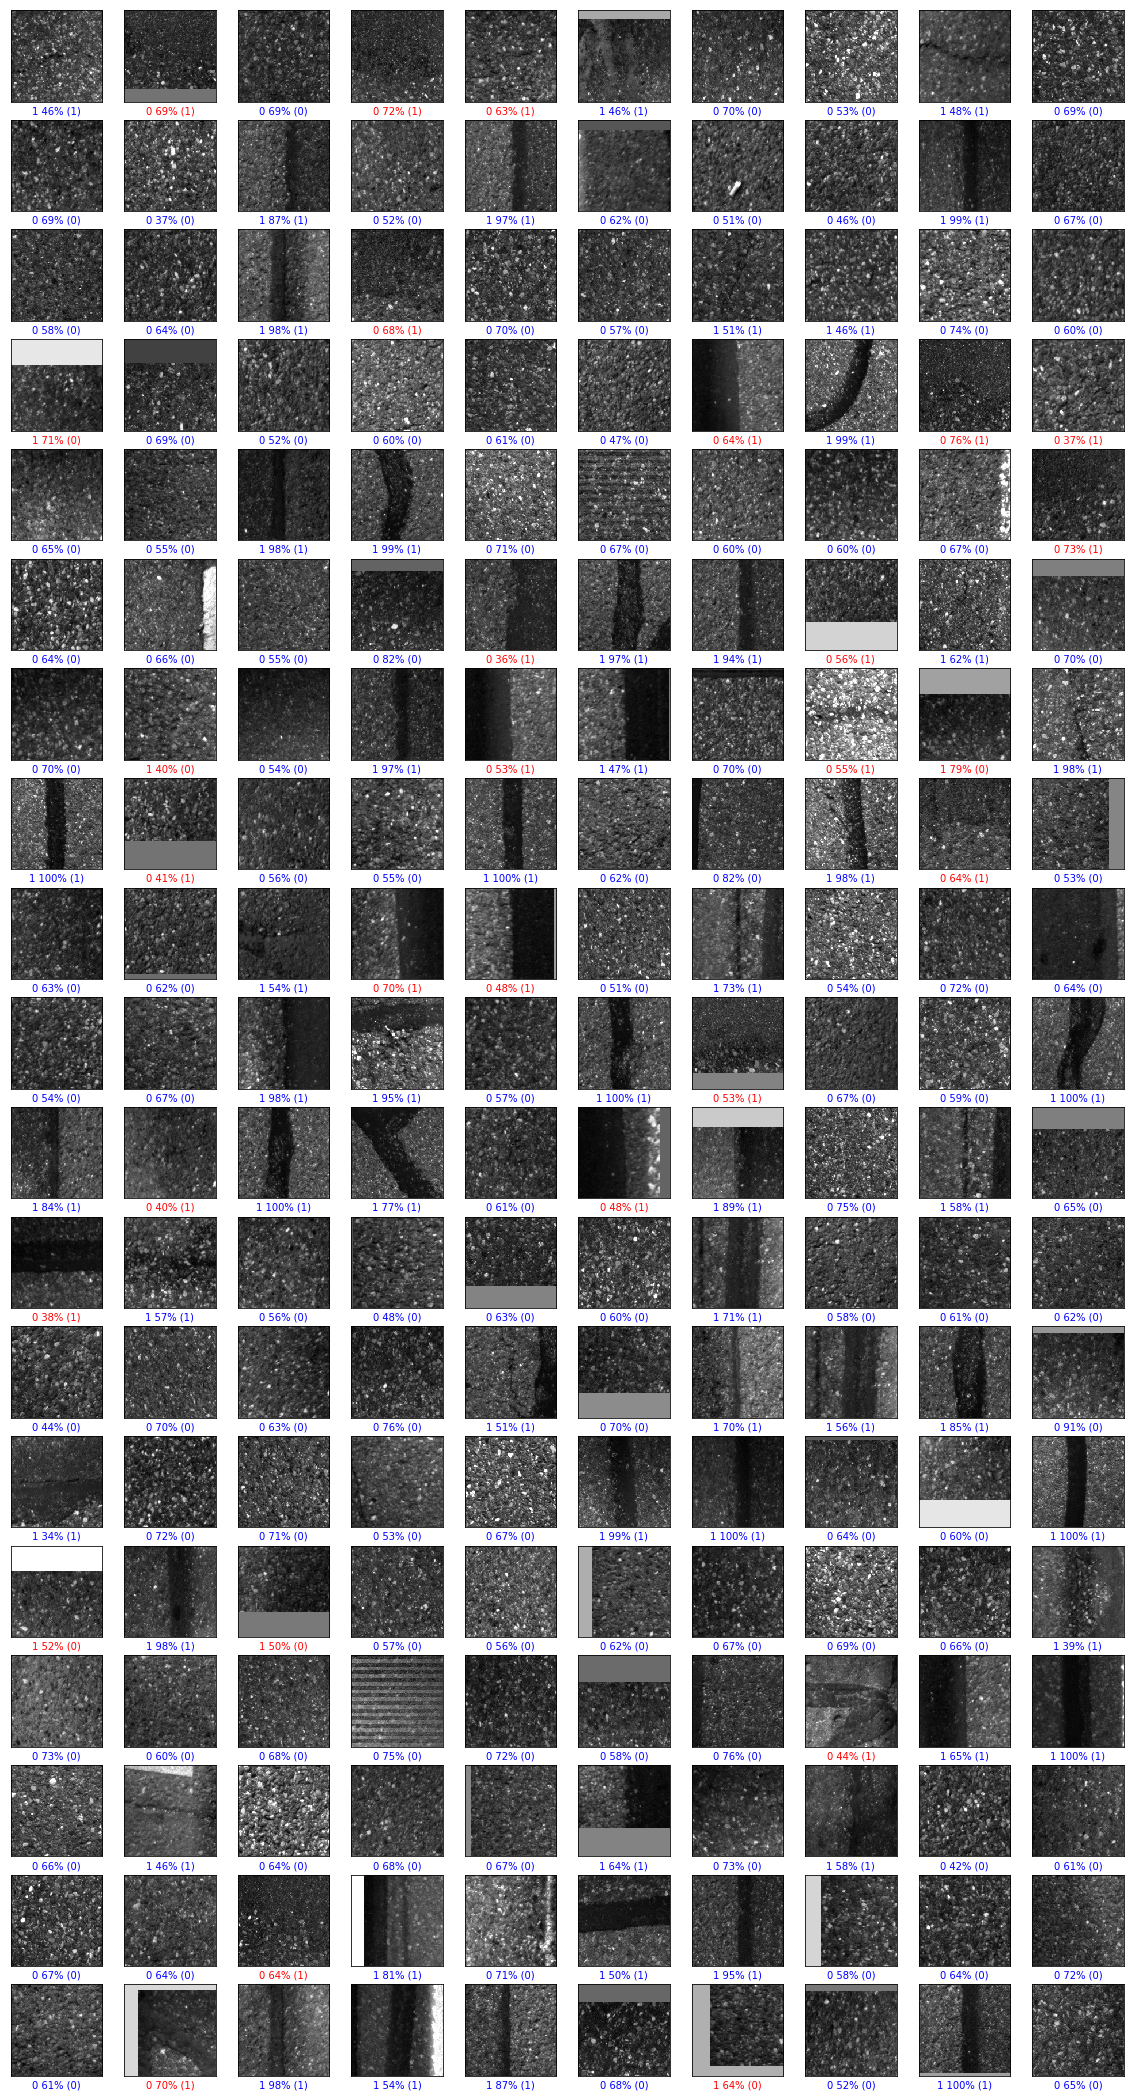

In [20]:

#이미지, 정답 여부, 퍼센트 출력
num_rows = 19
num_cols = 10
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(i, predictions, Ytest, Xtest)
plt.show()

In [21]:
pred = []
for i in range(len(Ytest)):
    pred.append(np.argmax(predictions[i]))
    
pred[1]

0


 TP : 58 
 FN : 24 
 FP : 6 
 TN : 111 

Accuracy(정분류율=(TP+TN)/(TP+FN+FP+TN)): 84.92%
Error_rate(오분류율=(FP+FN)/(TP+FN+FP+TN): 15.08%
Precirion(정확도=TP/(TP+FP)): 90.62%
Recall(재현율,민감도=TP/(TP+FN)): 70.73%




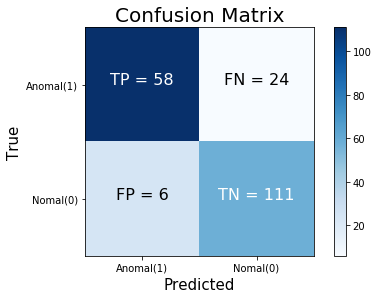

In [22]:
from sklearn.metrics import confusion_matrix #confusion matrix 라이브러리 임포트

con_mat = confusion_matrix(Ytest, pred) #confusion matrix 함수 실행

TP = con_mat[1][1] #둘다 Anomal이며, 예측값이 positive(이상값)
FN = con_mat[1][0] #실제값과 예측값이 달랐으며, 예측값이 negative(정상값)
FP = con_mat[0][1] #실제값과 예측값이 달랐으며, 예측값이 postive(이상값)
TN = con_mat[0][0] #둘다 nomal이며, 예측값이 negative(정상값)
print('\n',
      'TP :', TP, '\n', 
      'FN :', FN, '\n', 
      'FP :', FP, '\n', 
      'TN :', TN, '\n')

Accuracy = (TP+TN)/(TP+FN+FP+TN) #정분류율: 전체관측치 중 실제값과 예측치가 일치하는 정도
print('Accuracy(정분류율=(TP+TN)/(TP+FN+FP+TN)):', '{:.2%}'.format(Accuracy))

Error_rate = (FP+FN)/(TP+FN+FP+TN) #오분류율: 전체 관측치 중 실제값과 예측치가 다른 정보 (1-accuracy)
print('Error_rate(오분류율=(FP+FN)/(TP+FN+FP+TN):', '{:.2%}'.format(Error_rate))

Precirion = TP/(TP+FP) #정확도: TRUE로 예측한 관측치 중 실제값이 TRUE인 정도
print('Precirion(정확도=TP/(TP+FP)):', '{:.2%}'.format(Precirion))

Recall = TP/(TP+FN) #재현율: 실제값이 TRUE인 관측치 중 예측치가 적중한 정도, 민감도
print('Recall(재현율,민감도=TP/(TP+FN)):', '{:.2%}'.format(Recall))

print('\n')

# Confusion Matrix 표 그리기
plt.imshow(con_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Plot 구성하기
plt.title('Confusion Matrix', fontsize=20) # Plot 이름
plt.tight_layout()
plt.colorbar()
label=["Anomal(1)", "Nomal(0)"] # 라벨값
tick_marks = np.arange(len(label)) 
plt.xticks(tick_marks, label)
plt.yticks(tick_marks, label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)

# 표 안에 숫자 기입
name = [['TP','FN'], ['FP', 'TN']]
thresh = con_mat.max() / 2.
for i in range(2):
     for j in range(2):
        plt.text(j, i, str(name[i][j])+" = "+str(con_mat[1-i, 1-j]),
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] > thresh else "black",
                 fontsize=16)
    
plt.show()

In [29]:
#Grad CAM
gradFN=[] #grad에 정상으로 잘못 예측한 인덱스 출력하기
for i in range(len(pred)):
    if (pred[i] == 0 ):
        if (Ytest[i] == 1):
            gradFN.append(i)
print(gradFN)
print(len(gradFN))

[1, 3, 4, 23, 36, 38, 39, 49, 54, 57, 64, 67, 71, 78, 83, 84, 96, 101, 105, 110, 157, 172, 181, 194]
24


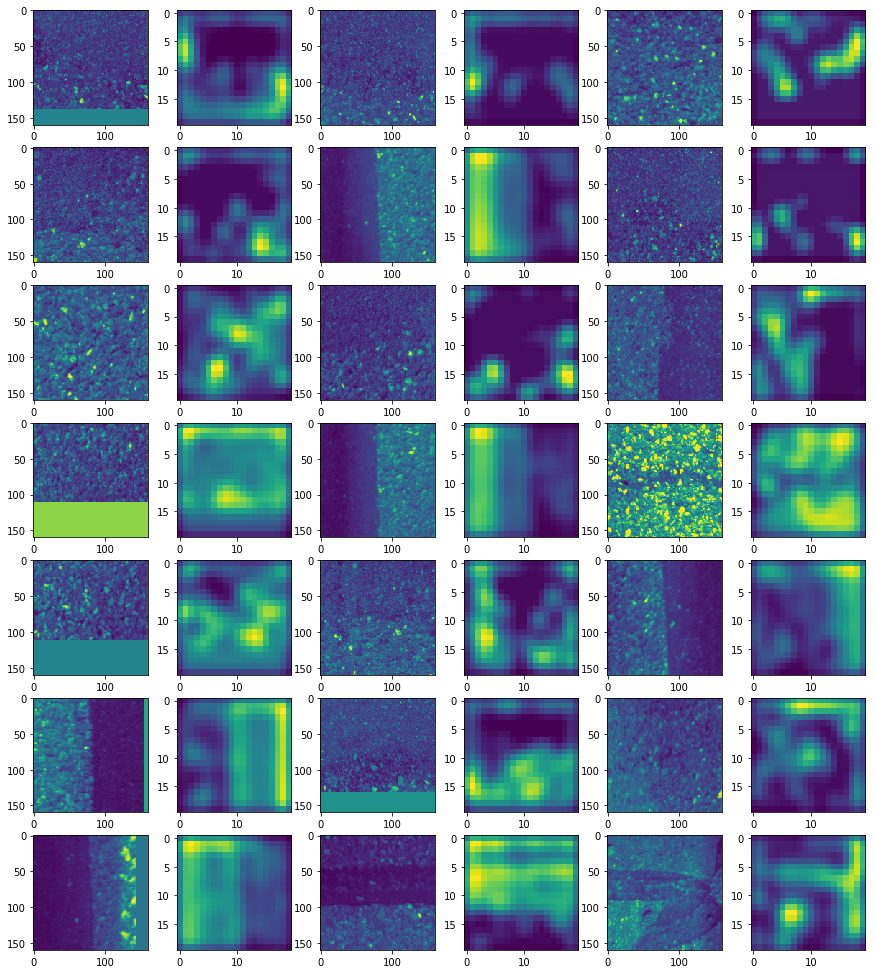

In [30]:
import tensorflow.keras.backend as K
from keras.preprocessing import image
import cv2

num_rows = 7
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*num_cols, 5*num_rows))
for i in range(num_images):    
    plt.subplot(2*num_rows, 2*num_cols, (2*i)+1)    
    x=Xtest[gradFN[i]]  # 예측 인덱스 
    shape = x.shape
    x_=x.reshape(1,shape[0],shape[1],shape[2]) 
    argmax = np.argmax(predictions[gradFN[i]])
    output = model.output[:, argmax]     # 예측 클래스를 output으로 지정
    last_conv_layer = model.get_layer('target_conv')    # 마지막 conv 층 불러오기
    # input img 는 feature map 
    grads = K.gradients(output,last_conv_layer.output)[0] #loss,input_img   
    pooled_grads = K.mean(grads, axis=(0, 1, 2))  # 특성 맵 채널별 그래디언트 평균 값이 담긴 벡터
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]]) # 샘플 이미지가 주어졌을 때 pooled_grads와 target_conv의 특성 맵 출력을 구한다 
    pooled_grads_value, conv_layer_output_value = iterate([x_])  # 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻는다
    for j in range(128):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]     # 클래스에 대한 '채널의 중요도'를 특성 맵 배열의 채널에 곱한다 
    heatmap = np.mean(conv_layer_output_value, axis=-1)    # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵
    plt.imshow(np.squeeze(Xtest[gradFN[i]]))
    plt.subplot(2*num_rows, 2*num_cols, (2*i)+2)   
    plt.imshow(heatmap)    #히트맵을 그려준다
   # plt.xlabel("{} : {} ({})".format(grad[i], pred[grad[i]], Ytest[grad[i]]))
plt.show()

In [27]:

#Grad CAM
gradTP=[] #grad에 비정상으로 맞게 예측한 인덱스 출력하기
for i in range(len(pred)):
    if (pred[i] == 1):
        if ( Ytest[i] == 1):
            gradTP.append(i)
print(gradTP)
print(len(gradTP))

[0, 5, 8, 12, 14, 18, 22, 26, 27, 37, 42, 43, 55, 56, 58, 63, 65, 69, 70, 74, 77, 82, 86, 92, 93, 95, 99, 100, 102, 103, 106, 108, 111, 116, 124, 126, 127, 128, 130, 135, 136, 139, 141, 149, 158, 159, 161, 165, 167, 173, 175, 176, 182, 183, 184, 188, 193, 197]
58


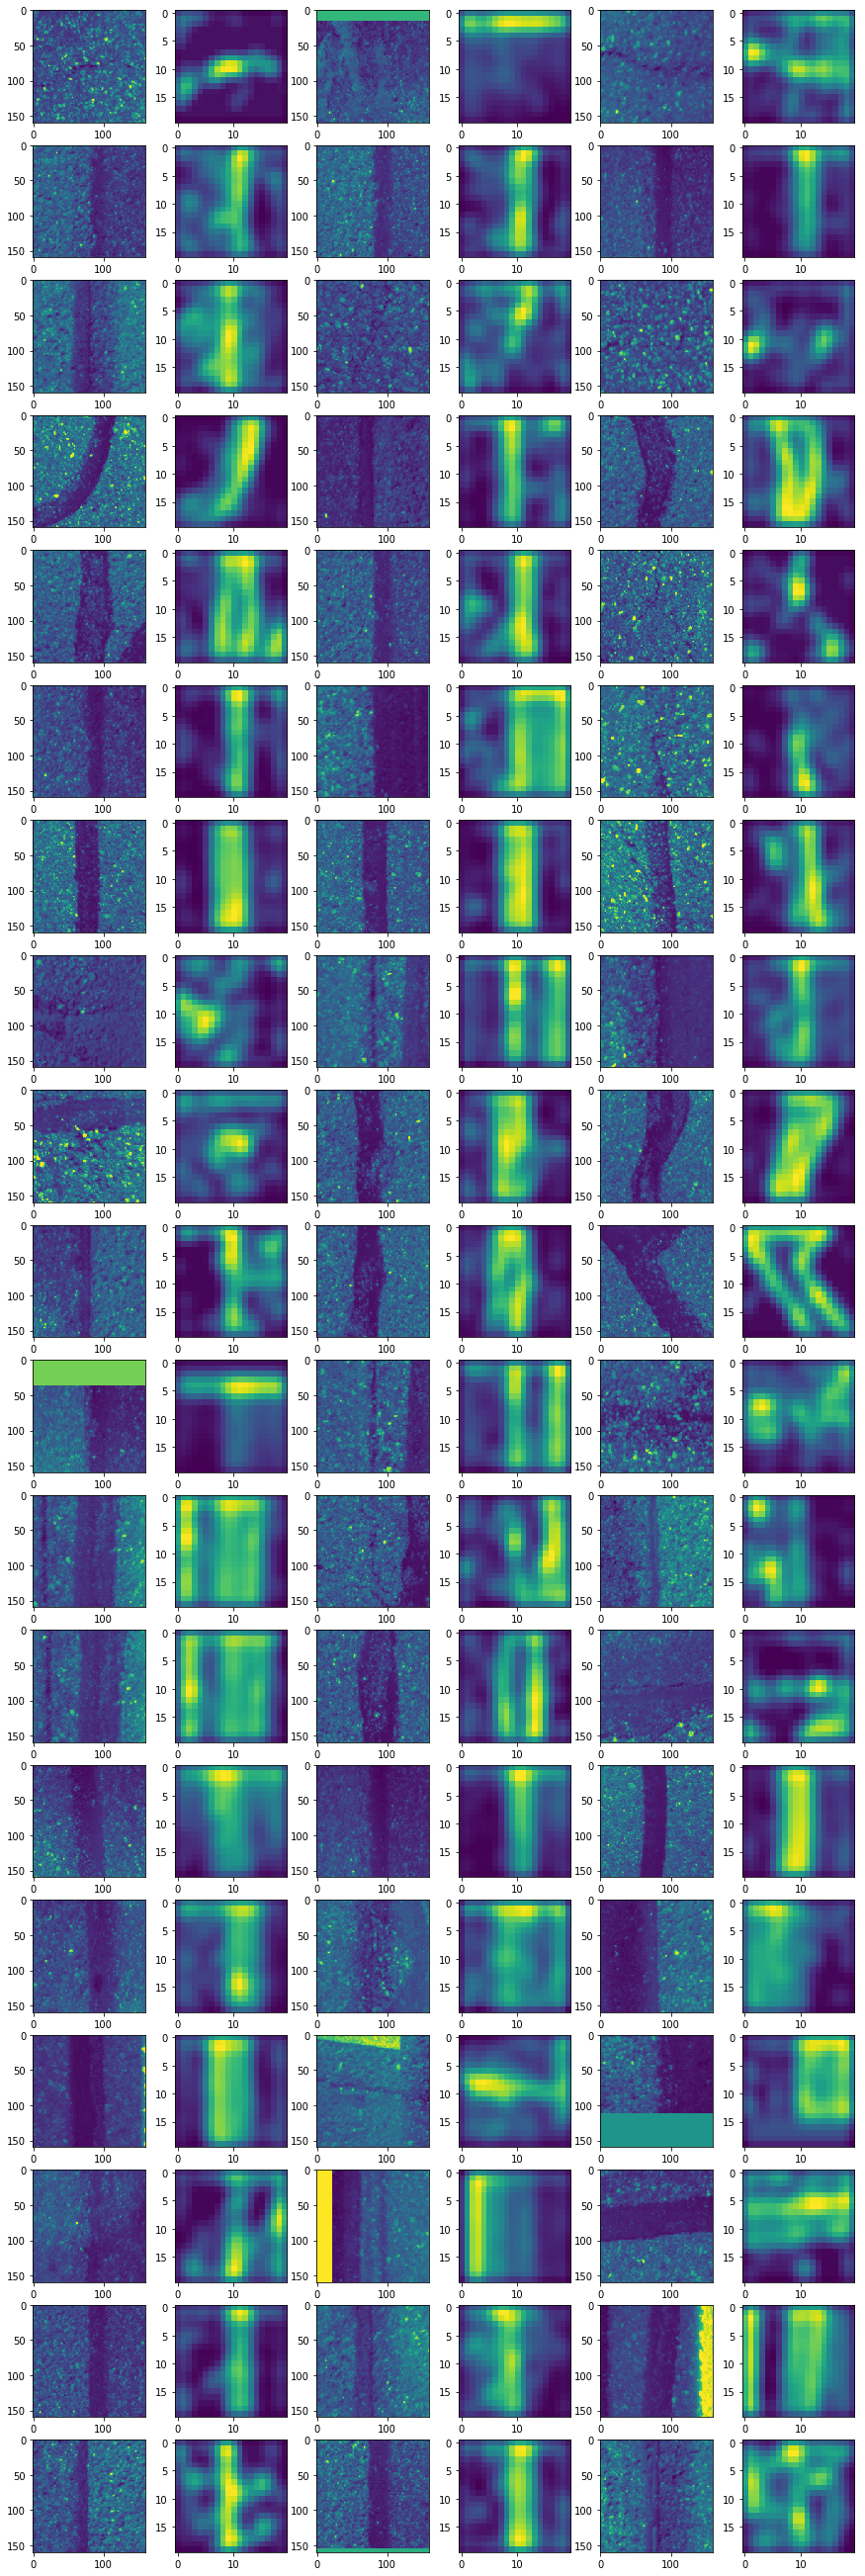

In [28]:
import tensorflow.keras.backend as K
from keras.preprocessing import image
import cv2

num_rows = 19
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*num_cols, 5*num_rows))
for i in range(num_images):    
    plt.subplot(2*num_rows, 2*num_cols, (2*i)+1)    
    x=Xtest[gradTP[i]]  # 예측 인덱스 
    shape = x.shape
    x_=x.reshape(1,shape[0],shape[1],shape[2]) 
    argmax = np.argmax(predictions[gradTP[i]])
    output = model.output[:, argmax]     # 예측 클래스를 output으로 지정
    last_conv_layer = model.get_layer('target_conv')    # 마지막 conv 층 불러오기
    # input img 는 feature map 
    grads = K.gradients(output,last_conv_layer.output)[0] #loss,input_img   
    pooled_grads = K.mean(grads, axis=(0, 1, 2))  # 특성 맵 채널별 그래디언트 평균 값이 담긴 벡터
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]]) # 샘플 이미지가 주어졌을 때 pooled_grads와 target_conv의 특성 맵 출력을 구한다 
    pooled_grads_value, conv_layer_output_value = iterate([x_])  # 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻는다
    for j in range(128):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]     # 클래스에 대한 '채널의 중요도'를 특성 맵 배열의 채널에 
​곱한다 
    heatmap = np.mean(conv_layer_output_value, axis=-1)    # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵
    plt.imshow(np.squeeze(Xtest[gradTP[i]]))
    plt.subplot(2*num_rows, 2*num_cols, (2*i)+2)   
    plt.imshow(heatmap)    #히트맵을 그려준다
   # plt.xlabel("{} : {} ({})".format(grad[i], pred[grad[i]], Ytest[grad[i]]))
plt.show()